In [938]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.stats import norm

In [939]:
def comma_string_to_float(input: str) -> float:
    """
    Converter function that parses numerical strings with comma decimal separators into floats.
    """
    return float(input.replace(',', '.'))

In [940]:
filenames = [
    ('Interferenz', 'data/TD/TD_Interferenz_20Hz_10V_50000Sample-500kHz.dat'),
    ('Messwerte', 'data/TD/TD_Interferenz_20Hz_10V_Interferenzmuster.dat'),
    ('Nullstellen', 'data/TD/TD_Interferenz_20Hz_10V_Nullstellen_50000Sample-500kHz.dat')
]

# Number of samples
n_samples = 50000
# Sample rate [Hz]
f_sample = 500000
# Frequency of the speaker [Hz]
f_speaker = 20

arr_dict = {}
for name, filename in filenames:
    arr_dict[name] = np.genfromtxt(
        fname=filename,
        encoding='iso-8859-1',
        converters={0: comma_string_to_float}
    )

In [941]:
# Select one of the arrays
name = 'Nullstellen'
U_arr = arr_dict[name]

# Substract the mean voltage
U_arr = (U_arr - U_arr.mean()) / U_arr.std()
print(U_arr.mean(), U_arr.std())

# Build an array for the time axis:
# Calculate the total duration [s]
total_duration = n_samples / f_sample
# Create an array
t_arr = np.linspace(0, total_duration, n_samples)

1.1095835361629724e-15 1.0


In [942]:
# Fit a sine curve to suppress the signal from the speaker itself
f_U_speaker = lambda t, A, t_off: A * np.cos(2 * np.pi * f_speaker * (t + t_off))

# Guess initial params
params_0_sine = [1.2, 0]

params_sine, _ = curve_fit(f_U_speaker, t_arr, U_arr, p0=params_0_sine)
print('Sine fit:', params_sine)
f_U_speaker_fit = lambda t: f_U_speaker(t, *params_sine)

Sine fit: [1.32331466e+00 5.61290409e-06]


In [943]:
# Subtract the fitted curve from the measurements
U_arr_OCT = U_arr - f_U_speaker_fit(t_arr)

# Select on of the interference patters
t_lims = [0.01, 0.014]
lim_inds = np.argwhere(np.logical_and(t_lims[0] <= t_arr, t_arr < t_lims[1])).flatten()
t_arr_IF = t_arr[lim_inds]
U_arr_IF = U_arr_OCT[lim_inds]

In [944]:
# Find the positions of the maxima
def find_max_inds(a: np.ndarray) -> np.ndarray:
    bool_arr = np.logical_and(
        a[:-2] < a[1:-1],
        a[1:-1] > a[2:]
    )
    false_arr = np.array([False])

    return np.concatenate([
        false_arr,
        bool_arr,
        false_arr
    ])

max_inds = find_max_inds(U_arr_IF)
min_inds = find_max_inds(-U_arr_IF)

extremum_inds = np.logical_or(max_inds, min_inds)
t_arr_IF_ex = t_arr_IF[extremum_inds]
U_arr_IF_ex = abs(U_arr_IF[extremum_inds])

In [945]:
# Select a subset of exteme values around the peak
peak_tlims = [0.0120, 0.0135]
peak_lim_inds = np.argwhere(np.logical_and(
    peak_tlims[0] <= t_arr_IF_ex,
    t_arr_IF_ex < peak_tlims[1]
)).flatten()

# Fit a Gaussian to the obtained extrema
f_gauss = lambda t, A, t_off, omega: A * np.exp(-(omega*(t - t_off)**2) / (16 * np.log(2)))
params_0_gauss = [1, 0.01275, 1]
params_gauss, _ = curve_fit(
    f_gauss,
    t_arr_IF_ex[peak_lim_inds],
    U_arr_IF_ex[peak_lim_inds],
    p0=params_0_gauss
)
print('Gauss fit:', params_gauss)

f_gauss_fit = lambda t: f_gauss(t, *params_gauss)

Gauss fit: [2.64771018e+00 1.27179590e-02 2.50298127e+07]


/home/jakob/miniconda3/envs/fprak/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


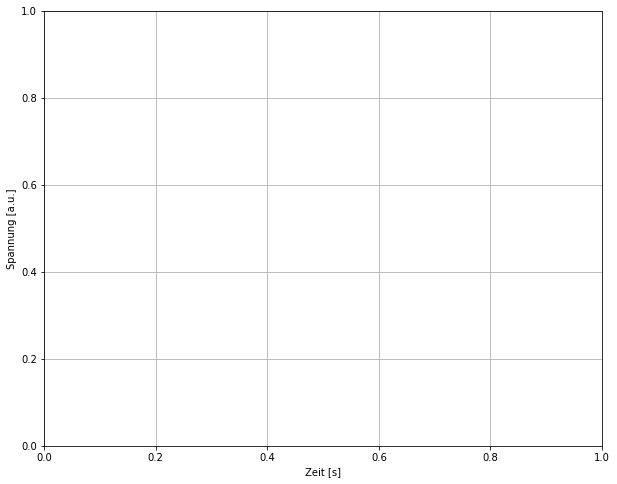

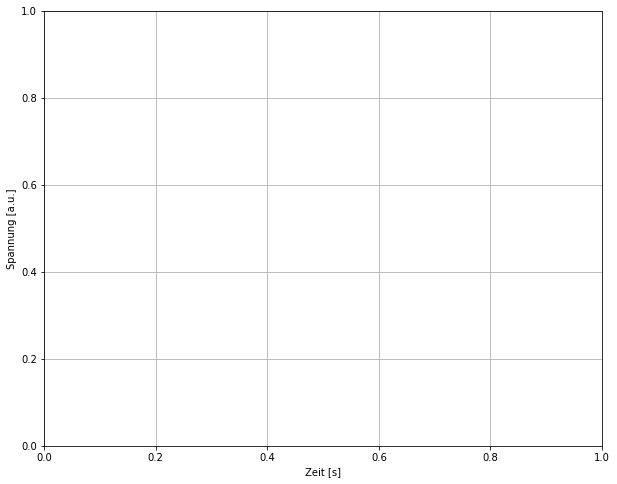

In [946]:
# Create and format plots
figlist = [plt.subplots(figsize=(10,8)) for _ in range(2)]
figs = [e[0] for e in figlist]
axes = [e[1] for e in figlist]

for ax in axes:
    ax.grid()
    ax.set_xlabel('Zeit [s]')
    ax.set_ylabel('Spannung [a.u.]')

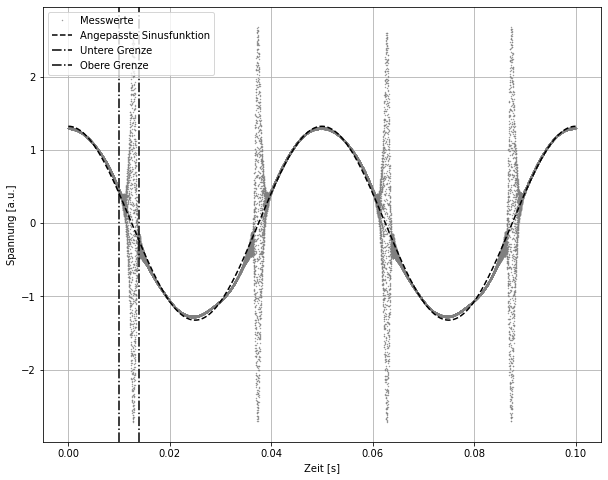

In [947]:
# Plot the measurements
axes[0].plot(t_arr, U_arr, '.', c='gray', ms=0.8, label='Messwerte')
# Plot the fitted sine function
axes[0].plot(t_arr, f_U_speaker_fit(t_arr), 'k--', label='Angepasste Sinusfunktion')
# Plot the limits of the interferece pattern
for limit, label in zip(t_lims, ['Untere Grenze', 'Obere Grenze']):
    axes[0].axvline(limit, ls='-.', c='k',  label=label)

axes[0].legend()
figs[0]

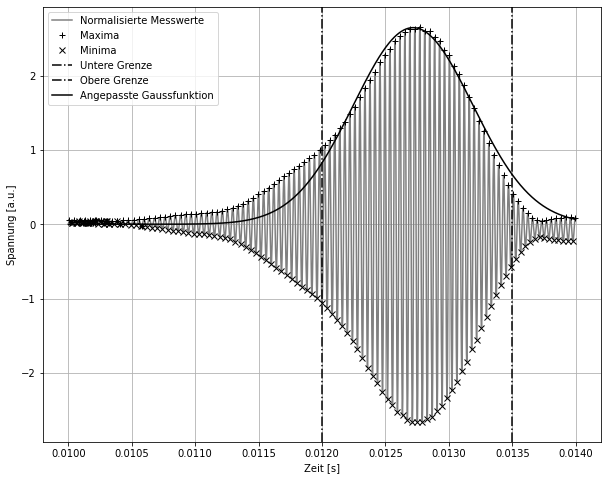

In [948]:
# Plot the interference pattern
axes[1].plot(t_arr_IF, U_arr_IF, '-', color='gray', label='Normalisierte Messwerte')
# Plot the minima/maxima
for inds, label, marker in zip(
    [max_inds, min_inds],
    ['Maxima', 'Minima'],
    ['k+', 'kx']
):
    axes[1].plot(t_arr_IF[inds], U_arr_IF[inds], marker, label=label)
# Plot the limits of the pattern used for the Gauss fit
for limit, label in zip(peak_tlims, ['Untere Grenze', 'Obere Grenze']):
    axes[1].axvline(limit, ls='-.', c='k',  label=label)

# Plot the Gauss fit
axes[1].plot(t_arr_IF, f_gauss_fit(t_arr_IF), 'k-', label='Angepasste Gaussfunktion')

axes[1].legend()
figs[1]

In [949]:
# Save the plots to disk
for fig, fname in zip(figs, ['normalisierung', 'einhüllende']):
    fig.savefig(f'figs/aufgabe1-{fname}.png', dpi=300, bbox_inches='tight')